# State Farm Distracted Driver Detection


[State Farm Distracted Driver Detection](https://www.kaggle.com/c/state-farm-distracted-driver-detection#evaluation)

## Action Plan
### 1. Data Preparation and Preprocessing
### 2. Finetune and Train Model
### 2b. Data Augmentation parameter tuning
### 3. Generate and Validate Predictions 
### 4. Submit predictions to Kaggle

# 2b. Data Augmentation parameter tuning

## Setup 

In [1]:
%cd "~/kaggle/state-farm-driver-detection/code"
%pwd

/home/ubuntu/kaggle/state-farm-driver-detection/code


'/home/ubuntu/kaggle/state-farm-driver-detection/code'

In [2]:
#Create references to important directories we will use over and over
import os, sys
current_dir = os.getcwd()
CODE_HOME_DIR = current_dir
DATA_HOME_DIR = CODE_HOME_DIR + '/../input/'
print(CODE_HOME_DIR)
print(DATA_HOME_DIR)

/home/ubuntu/kaggle/state-farm-driver-detection/code
/home/ubuntu/kaggle/state-farm-driver-detection/code/../input/


In [3]:
#import modules
#from importlib import reload

import utils
from utils import *

import vgg16bn_ted
from vgg16bn_ted import Vgg16BN; 

%matplotlib inline

Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


#### Setup Paths

In [4]:
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR + '/' # + '/sample/' 
results_path = path + 'results/'
train_path = path + 'train/'
valid_path = path + 'valid/'
test_path = path + 'test/'
model_path = path + 'models/'
if not os.path.exists(model_path): os.makedirs(model_path)
    
batch_size = 64

/home/ubuntu/kaggle/state-farm-driver-detection/input


### Load conv_model pretrain features from 2. ModelTuning


**<br><font color='red'>Notices:</font>** ** <font color='red'>batches shuffle must be set to False when pre-computing features </font>**


In [5]:
(trn_classes, val_classes, trn_labels, val_labels, trn_filenames, val_filenames, test_filenames) = get_classes(path)

Found 17940 images belonging to 10 classes.
Found 4484 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.


#### Train and save Pretrained conv_model Feature Maps

In [6]:
conv_trn_features = load_array(results_path+'train_convlayer_features.dat')
conv_val_features = load_array(results_path+'valid_convlayer_features2.dat')
conv_test_features = load_array(results_path+'test_convlayer_features.dat')

In [7]:
print(conv_trn_features.shape)
print(conv_val_features.shape)
print(conv_test_features.shape)

(17940, 512, 8, 8)
(4484, 512, 8, 8)
(79726, 512, 8, 8)


# 2b. Data Augmentation parameter tuning

## Data Augmentation
#### The best practice is to test the 4 types for each of the parameter based on a fixed “sample set” and on big enough validation set to test the value of each parameters improve the accuracy for this whole process. Finally, just combine each of the data augmentation altogether. 

#### Adjust Data Augmentation parameters

In [27]:
# for display purposes, data_format='channels_last'this is more convenient
gen = image.ImageDataGenerator(rotation_range=20.0, width_shift_range=0.08, height_shift_range=0.08,
                              shear_range=0.15, zoom_range=0.1, channel_shift_range=10.,
                              horizontal_flip=True, data_format='channels_last')


Found 79726 images belonging to 1 classes.


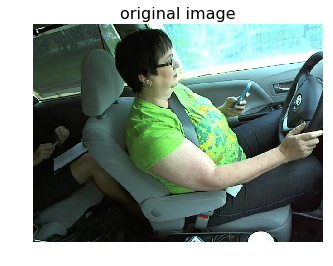

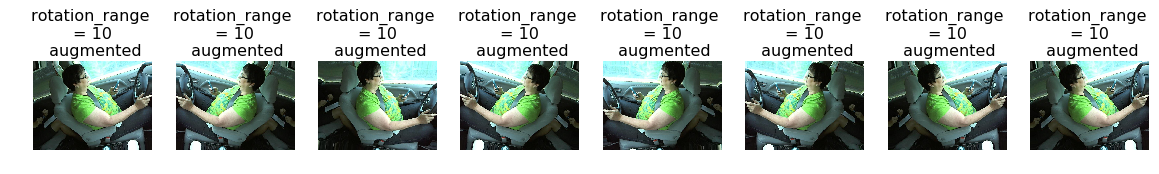

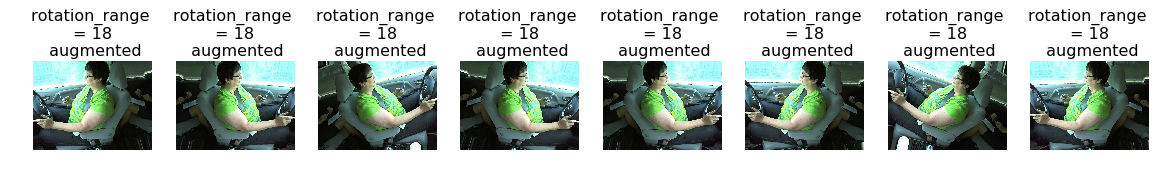

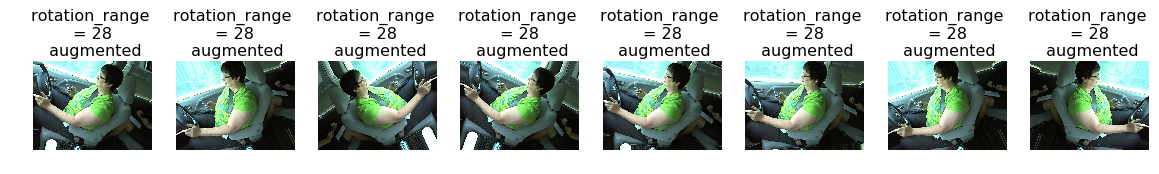

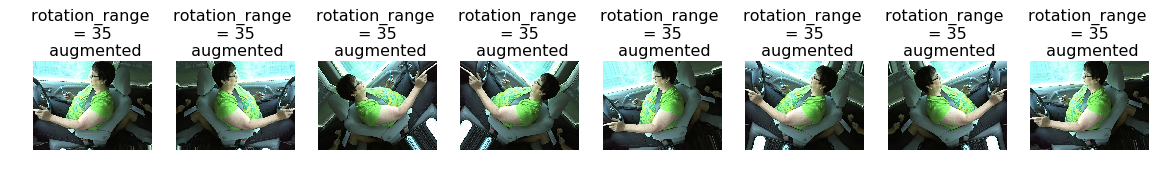

In [28]:
augment_view('rotation_range', [10, 18, 28, 35], test_path) # 28 ok

Found 79726 images belonging to 1 classes.


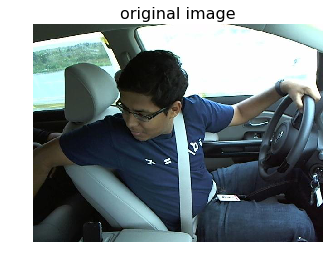

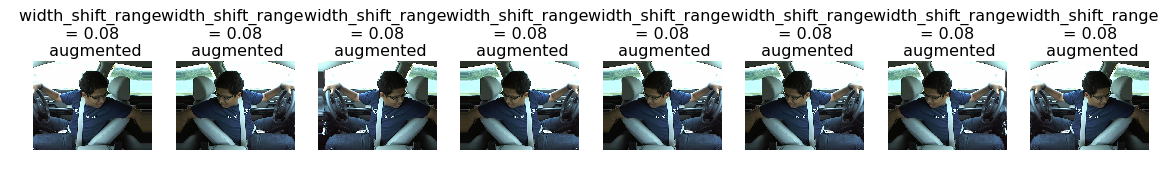

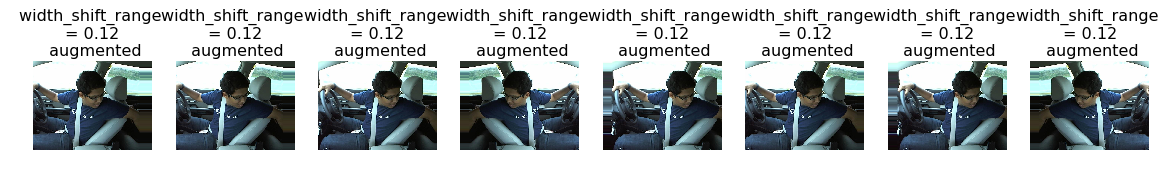

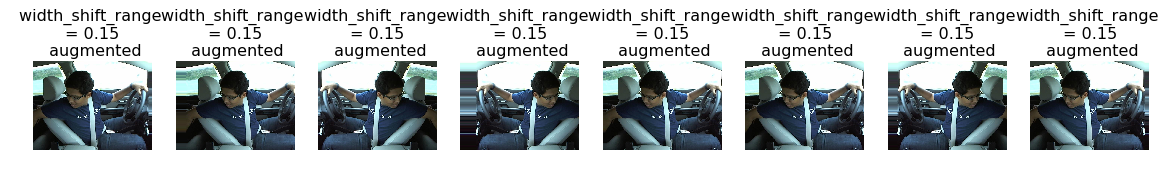

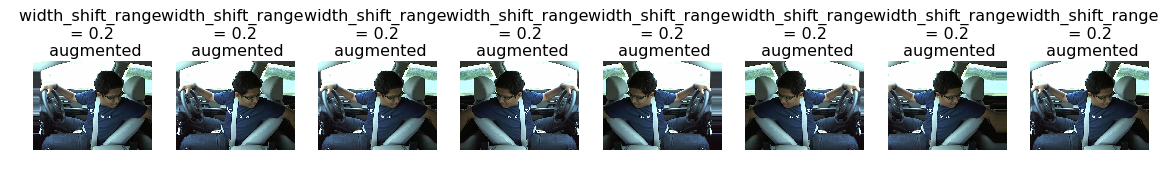

In [29]:
augment_view('width_shift_range', [0.08, 0.12, 0.15, 0.2], test_path) # 0.15 ok

Found 79726 images belonging to 1 classes.


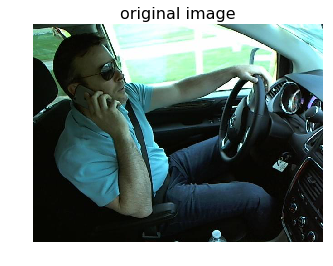

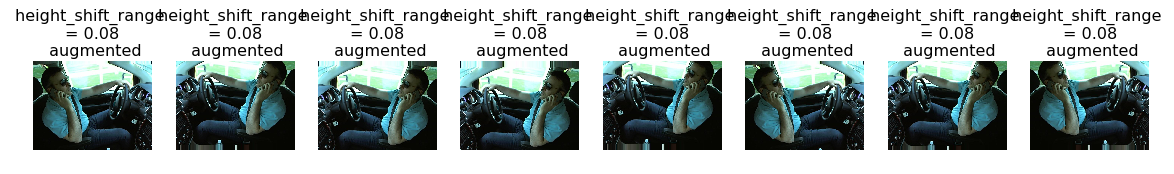

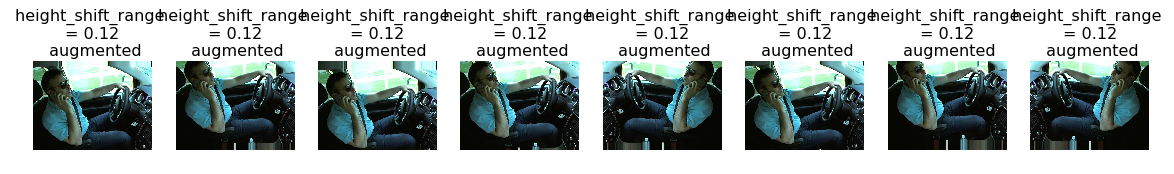

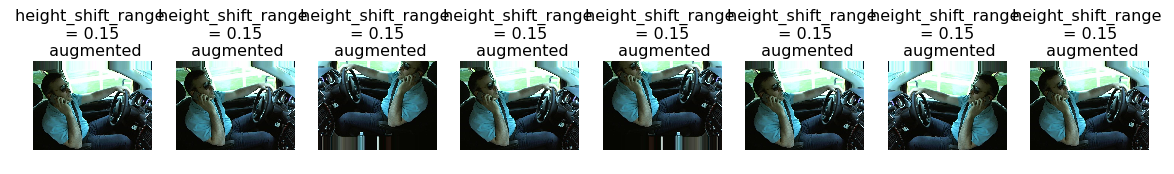

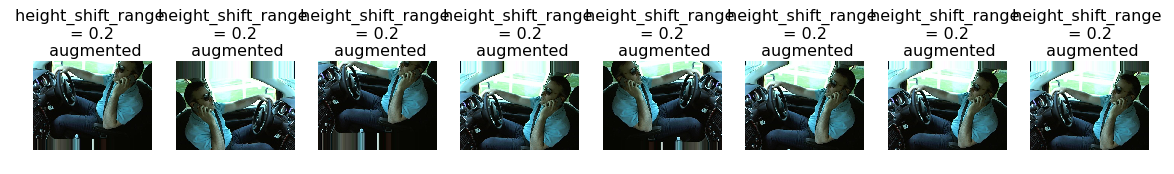

In [30]:
augment_view('height_shift_range', [0.08, 0.12, 0.15, 0.2], test_path)  # 0.08 ok

Found 79726 images belonging to 1 classes.


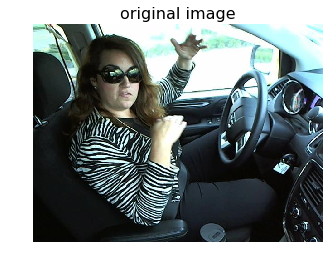

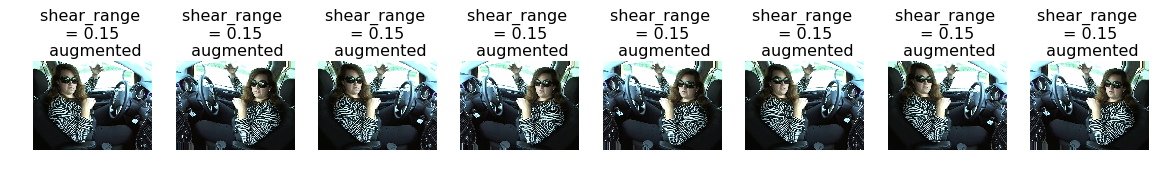

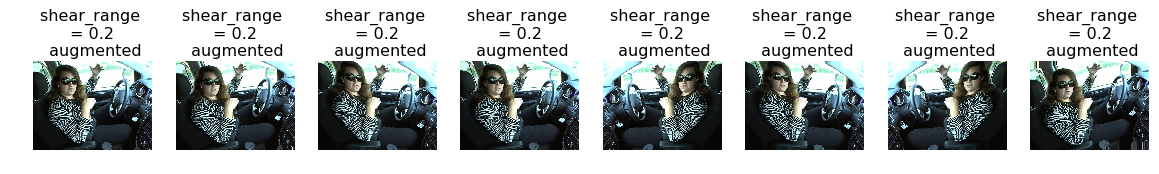

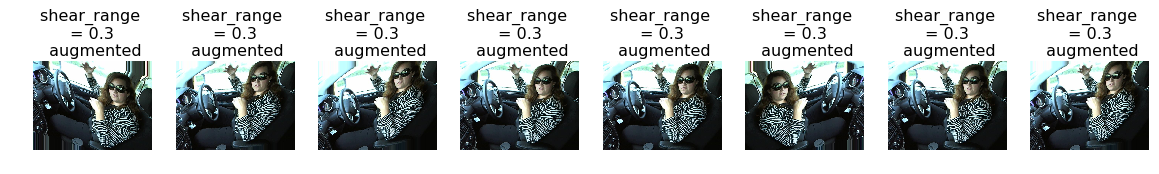

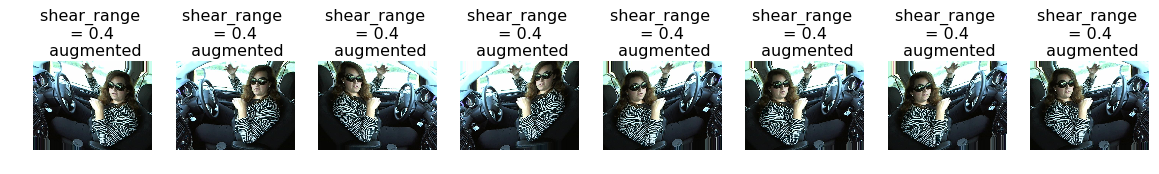

In [31]:
augment_view('shear_range', [0.15, 0.2, 0.3, 0.4], test_path)  # 0.4 ok

Found 79726 images belonging to 1 classes.


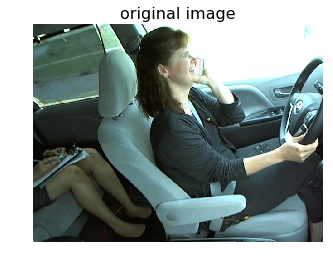

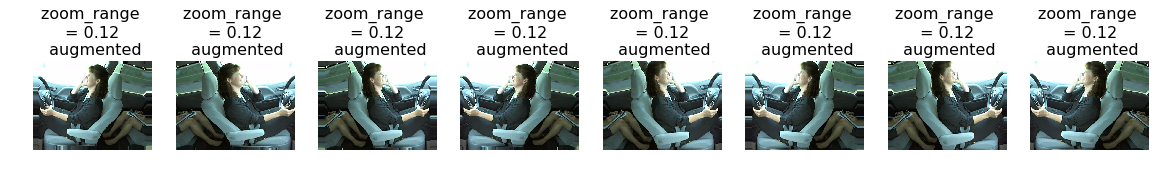

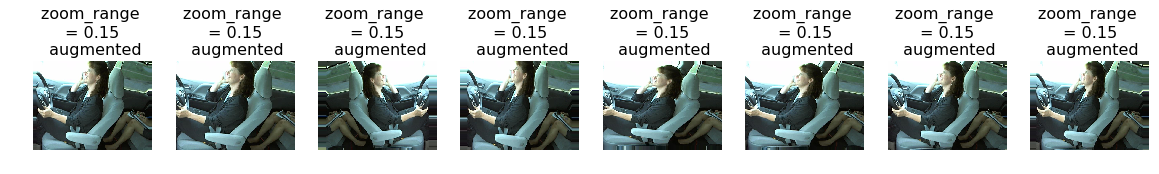

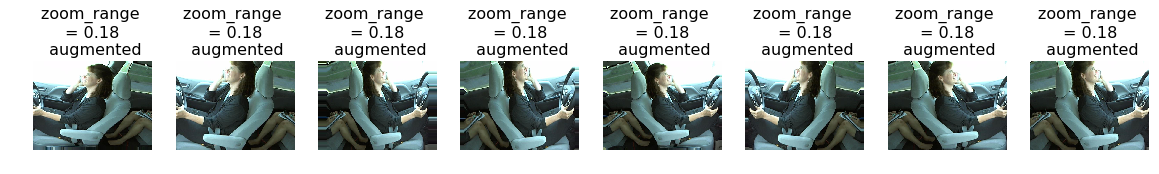

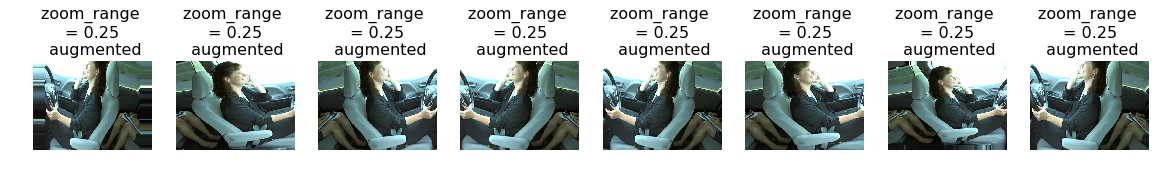

In [32]:
augment_view('zoom_range', [0.12, 0.15, 0.18, 0.25], test_path) # 0.18 ok

Found 79726 images belonging to 1 classes.


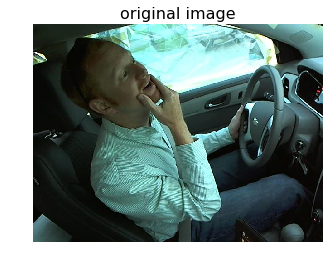

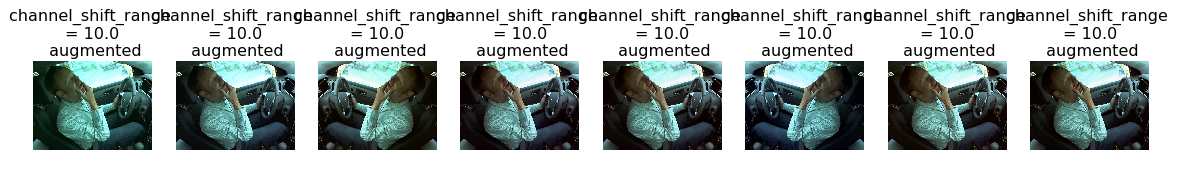

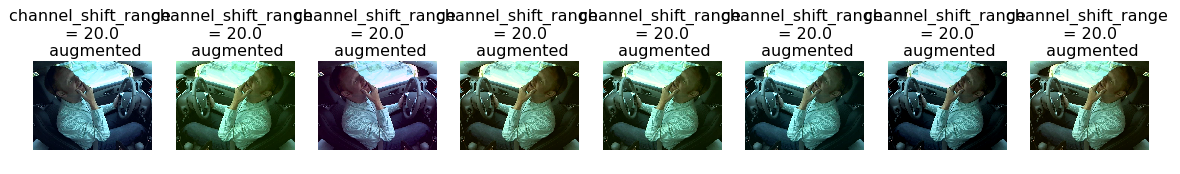

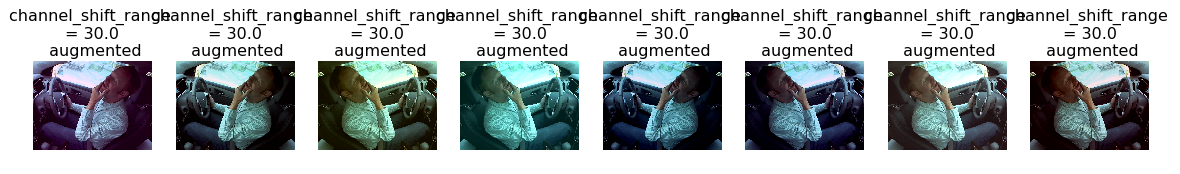

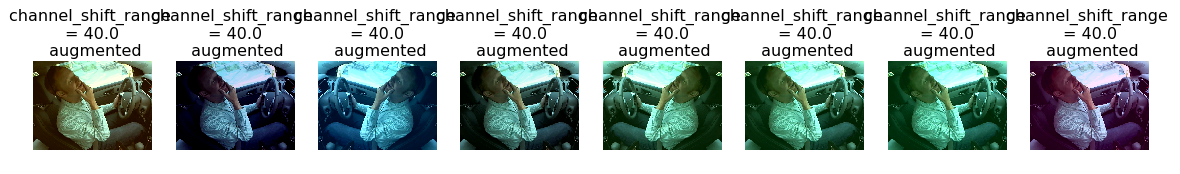

In [33]:
augment_view('channel_shift_range', [10.,20.,30.,40.], test_path) # 30. ok

In [34]:
K.set_image_data_format('channels_first')

### Adding data augmentation to tune model

#### Setup: use our data augmentation parameters to create a 6x blended training datasets (5x data aug + 1x raw) 
- ** Notice that here because we use this BatchNormalization dense layers based on pretrained convolution layers, we can not use Data Augmentation, because with Data Augmentation the output of pretrained convolution layers will be different every time **
- ** But you could compute 10x bigger than your dataset like 10 different versions of it. This is why I put it here with data augmentation generator and then predict it like 5 times bigger of data. This would give me 5 times of data. This actually works pretty well. It’s not as good as giving a whole new sample every time but it’s kind of a compromise **

In [9]:
def aug_model_train(param_name, choices, batch_size=64):
    vgg = Vgg16BN(size=(256, 256))
    #Finetune the model
    vgg.ft(10)
    model = vgg.model
    #set_trainable(model)
        
    for c in choices:
        print("\n"+param_name+" = "+str(c))
        if param_name is 'rotation_range':
            gen = image.ImageDataGenerator(rotation_range=c, horizontal_flip=True)
        elif param_name is 'width_shift_range':
            gen = image.ImageDataGenerator(width_shift_range=c, horizontal_flip=True)
        elif param_name is 'height_shift_range':
            gen = image.ImageDataGenerator(height_shift_range=c, horizontal_flip=True)
        elif param_name is 'shear_range':
            gen = image.ImageDataGenerator(shear_range=c, horizontal_flip=True)
        elif param_name is 'zoom_range':
            gen = image.ImageDataGenerator(zoom_range=c, horizontal_flip=True)
        elif param_name is 'channel_shift_range':
            gen = image.ImageDataGenerator(channel_shift_range=c, horizontal_flip=True)
        else:
            return
        
        aug_batches = get_batches(train_path, gen=gen, shuffle=False, batch_size=batch_size)
        
        conv_model, fc_model = get_split_models(model)
        conv_aug_features = conv_model.predict_generator(aug_batches, 
                                                         steps=ceil(aug_batches.n/aug_batches.batch_size), 
                                                         verbose=2)    
        fc_model.fit(conv_aug_features, trn_labels, batch_size=batch_size, epochs=4, 
             validation_data= (conv_val_features, val_labels), verbose=2)
        
        fc_model.optimizer.lr = 0.01
        
        fc_model.fit(conv_aug_features, trn_labels, batch_size=batch_size, epochs=5, 
             validation_data= (conv_val_features, val_labels), verbose=2)
        

#### rotation_range: 28 (0.9900) ####
`
Test Result: 
[10    , 18    , 23    , 28] 
[0.9853, 0.9877, 0.9893, 0.9900]
`

In [12]:
aug_model_train('rotation_range', [10, 18, 23, 28])  

Found 17940 images belonging to 10 classes.
Train on 17940 samples, validate on 4484 samples
Epoch 1/4
 - 58s - loss: 0.8838 - acc: 0.8021 - val_loss: 0.2482 - val_acc: 0.9411
Epoch 2/4
 - 54s - loss: 0.2133 - acc: 0.9493 - val_loss: 0.1705 - val_acc: 0.9650
Epoch 3/4
 - 54s - loss: 0.1311 - acc: 0.9672 - val_loss: 0.1488 - val_acc: 0.9723
Epoch 4/4
 - 54s - loss: 0.1265 - acc: 0.9708 - val_loss: 0.2211 - val_acc: 0.9648
Train on 17940 samples, validate on 4484 samples
Epoch 1/5
 - 54s - loss: 0.0845 - acc: 0.9812 - val_loss: 0.2118 - val_acc: 0.9603
Epoch 2/5
 - 54s - loss: 0.1015 - acc: 0.9804 - val_loss: 0.1376 - val_acc: 0.9786
Epoch 3/5
 - 54s - loss: 0.0910 - acc: 0.9804 - val_loss: 0.2738 - val_acc: 0.9599
Epoch 4/5
 - 54s - loss: 0.1101 - acc: 0.9796 - val_loss: 0.1042 - val_acc: 0.9844
Epoch 5/5
 - 54s - loss: 0.0836 - acc: 0.9833 - val_loss: 0.1077 - val_acc: 0.9853
Found 17940 images belonging to 10 classes.
Train on 17940 samples, validate on 4484 samples
Epoch 1/4
 - 56s -

#### width_shift_range: 0.15 (0.9951) ####
`
Test Result: 
[0.08, 0.1, 0.12, 0.15]
[0.9873, 0.9909, 0.9917, 0.9951]
`

In [12]:
aug_model_train('width_shift_range', [0.08, 0.1, 0.12, 0.15])


width_shift_range = 0.08
Found 17940 images belonging to 10 classes.
Train on 17940 samples, validate on 4484 samples
Epoch 1/4
 - 56s - loss: 0.8517 - acc: 0.8071 - val_loss: 0.1995 - val_acc: 0.9563
Epoch 2/4
 - 54s - loss: 0.1916 - acc: 0.9528 - val_loss: 0.3110 - val_acc: 0.9474
Epoch 3/4
 - 54s - loss: 0.1320 - acc: 0.9689 - val_loss: 0.2278 - val_acc: 0.9621
Epoch 4/4
 - 54s - loss: 0.1069 - acc: 0.9770 - val_loss: 0.0815 - val_acc: 0.9873
Train on 17940 samples, validate on 4484 samples
Epoch 1/5
 - 54s - loss: 0.1116 - acc: 0.9769 - val_loss: 0.1391 - val_acc: 0.9802
Epoch 2/5
 - 54s - loss: 0.0744 - acc: 0.9834 - val_loss: 0.1152 - val_acc: 0.9831
Epoch 3/5
 - 54s - loss: 0.1124 - acc: 0.9794 - val_loss: 0.1836 - val_acc: 0.9708
Epoch 4/5
 - 54s - loss: 0.0974 - acc: 0.9824 - val_loss: 0.0904 - val_acc: 0.9864
Epoch 5/5
 - 54s - loss: 0.0807 - acc: 0.9847 - val_loss: 0.1261 - val_acc: 0.9822

width_shift_range = 0.1
Found 17940 images belonging to 10 classes.
Train on 17940 s

#### height_shift_range: 0.08 (0.9955) ####
`
Test Result: 
[0.02,   0.04,   0.06, 0.08]
[0.9906, 0.9909, 0.9944, 0.9955]
`

In [9]:
aug_model_train('height_shift_range', [0.02, 0.04, 0.06, 0.08])


height_shift_range = 0.02
Found 17940 images belonging to 10 classes.
Train on 17940 samples, validate on 4484 samples
Epoch 1/4
 - 58s - loss: 0.7932 - acc: 0.8285 - val_loss: 0.1650 - val_acc: 0.9650
Epoch 2/4
 - 55s - loss: 0.1588 - acc: 0.9619 - val_loss: 0.0756 - val_acc: 0.9837
Epoch 3/4
 - 54s - loss: 0.1309 - acc: 0.9703 - val_loss: 0.2427 - val_acc: 0.9601
Epoch 4/4
 - 54s - loss: 0.0878 - acc: 0.9813 - val_loss: 0.1699 - val_acc: 0.9692
Train on 17940 samples, validate on 4484 samples
Epoch 1/5
 - 54s - loss: 0.0794 - acc: 0.9813 - val_loss: 0.1347 - val_acc: 0.9761
Epoch 2/5
 - 54s - loss: 0.0755 - acc: 0.9837 - val_loss: 0.0816 - val_acc: 0.9860
Epoch 3/5
 - 54s - loss: 0.0689 - acc: 0.9868 - val_loss: 0.1267 - val_acc: 0.9802
Epoch 4/5
 - 54s - loss: 0.0845 - acc: 0.9849 - val_loss: 0.1018 - val_acc: 0.9844
Epoch 5/5
 - 54s - loss: 0.0800 - acc: 0.9865 - val_loss: 0.0721 - val_acc: 0.9906

height_shift_range = 0.04
Found 17940 images belonging to 10 classes.
Train on 1794

#### shear_range: 0.3 (0.9935) ####
`
Test Result: 
[0.15,   0.2,   0.3,    0.4]
[0.9895, 0.9920,0.9935, 0.9935]
`

In [9]:
aug_model_train('shear_range', [0.15, 0.2, 0.3, 0.4])


shear_range = 0.15
Found 17940 images belonging to 10 classes.
Train on 17940 samples, validate on 4484 samples
Epoch 1/4
 - 56s - loss: 0.7401 - acc: 0.8283 - val_loss: 0.1445 - val_acc: 0.9643
Epoch 2/4
 - 54s - loss: 0.1854 - acc: 0.9556 - val_loss: 0.1261 - val_acc: 0.9690
Epoch 3/4
 - 54s - loss: 0.1291 - acc: 0.9700 - val_loss: 0.1534 - val_acc: 0.9701
Epoch 4/4
 - 54s - loss: 0.1112 - acc: 0.9750 - val_loss: 0.1286 - val_acc: 0.9788
Train on 17940 samples, validate on 4484 samples
Epoch 1/5
 - 54s - loss: 0.0905 - acc: 0.9808 - val_loss: 0.0637 - val_acc: 0.9888
Epoch 2/5
 - 54s - loss: 0.0839 - acc: 0.9838 - val_loss: 0.1317 - val_acc: 0.9793
Epoch 3/5
 - 54s - loss: 0.0796 - acc: 0.9841 - val_loss: 0.1588 - val_acc: 0.9770
Epoch 4/5
 - 54s - loss: 0.0826 - acc: 0.9842 - val_loss: 0.0890 - val_acc: 0.9871
Epoch 5/5
 - 54s - loss: 0.0885 - acc: 0.9843 - val_loss: 0.0807 - val_acc: 0.9895

shear_range = 0.2
Found 17940 images belonging to 10 classes.
Train on 17940 samples, vali

#### zoom_range: 0.18 (0.9942) ####
`
Test Result: 
[0.08, 0.12, 0.15, 0.18]
[0.9808, 0.9913, 0.9902, 0.9942]
`

In [9]:
aug_model_train('zoom_range', [0.08, 0.12, 0.15, 0.18])


zoom_range = 0.08
Found 17940 images belonging to 10 classes.
Train on 17940 samples, validate on 4484 samples
Epoch 1/4
 - 56s - loss: 0.7576 - acc: 0.8266 - val_loss: 0.2752 - val_acc: 0.9476
Epoch 2/4
 - 54s - loss: 0.1594 - acc: 0.9605 - val_loss: 0.1814 - val_acc: 0.9616
Epoch 3/4
 - 54s - loss: 0.1265 - acc: 0.9690 - val_loss: 0.1132 - val_acc: 0.9793
Epoch 4/4
 - 54s - loss: 0.0994 - acc: 0.9787 - val_loss: 0.1429 - val_acc: 0.9719
Train on 17940 samples, validate on 4484 samples
Epoch 1/5
 - 54s - loss: 0.0811 - acc: 0.9820 - val_loss: 0.1424 - val_acc: 0.9802
Epoch 2/5
 - 54s - loss: 0.0880 - acc: 0.9825 - val_loss: 0.3103 - val_acc: 0.9561
Epoch 3/5
 - 54s - loss: 0.0769 - acc: 0.9851 - val_loss: 0.1693 - val_acc: 0.9777
Epoch 4/5
 - 54s - loss: 0.0783 - acc: 0.9847 - val_loss: 0.1435 - val_acc: 0.9808
Epoch 5/5
 - 54s - loss: 0.0859 - acc: 0.9849 - val_loss: 0.1551 - val_acc: 0.9793

zoom_range = 0.12
Found 17940 images belonging to 10 classes.
Train on 17940 samples, valid

#### channel_shift_range: 30.(0.9955) ####
`
Test Result: 
[15.   , 20.   , 25.   , 30.]
[0.9920, 0.9920, 0.9944, 0.9955]
`

In [10]:
aug_model_train('channel_shift_range', [15.,20.,25.,30.])


channel_shift_range = 15.0
Found 17940 images belonging to 10 classes.
Train on 17940 samples, validate on 4484 samples
Epoch 1/4
 - 56s - loss: 0.7255 - acc: 0.8310 - val_loss: 0.1527 - val_acc: 0.9585
Epoch 2/4
 - 55s - loss: 0.1520 - acc: 0.9648 - val_loss: 0.0923 - val_acc: 0.9795
Epoch 3/4
 - 54s - loss: 0.1344 - acc: 0.9687 - val_loss: 0.1815 - val_acc: 0.9634
Epoch 4/4
 - 54s - loss: 0.0960 - acc: 0.9796 - val_loss: 0.0763 - val_acc: 0.9864
Train on 17940 samples, validate on 4484 samples
Epoch 1/5
 - 54s - loss: 0.0860 - acc: 0.9828 - val_loss: 0.1096 - val_acc: 0.9835
Epoch 2/5
 - 54s - loss: 0.0489 - acc: 0.9886 - val_loss: 0.0623 - val_acc: 0.9871
Epoch 3/5
 - 54s - loss: 0.0801 - acc: 0.9843 - val_loss: 0.2020 - val_acc: 0.9677
Epoch 4/5
 - 54s - loss: 0.0810 - acc: 0.9848 - val_loss: 0.2516 - val_acc: 0.9616
Epoch 5/5
 - 54s - loss: 0.0642 - acc: 0.9889 - val_loss: 0.0579 - val_acc: 0.9920

channel_shift_range = 20.0
Found 17940 images belonging to 10 classes.
Train on 17

## Final Conclusion of Data Augmentation parameters ###
**
`
rotation_range=28., 
width_shift_range=0.15, 
height_shift_range=0.08, 
shear_range=0.3, 
zoom_range=0.18, 
channel_shift_range=30.
`
**

In [8]:
def aug_model_full_train():
    vgg = Vgg16BN(size=(256, 256))
    #Finetune the model
    vgg.ft(10)
    model = vgg.model
    #set_trainable(model)
        
    gen = image.ImageDataGenerator(rotation_range=28., width_shift_range=0.15, height_shift_range=0.08, 
                                       shear_range=0.3, zoom_range=0.18, channel_shift_range=30.,
                                       horizontal_flip=True)
        
    aug_batches = get_batches(train_path, gen=gen, shuffle=False, batch_size=batch_size)
        
    conv_model, fc_model = get_split_models(model)
    conv_aug_features = conv_model.predict_generator(aug_batches, 
                                                     steps=ceil(aug_batches.n/aug_batches.batch_size), 
                                                     verbose=2)    
    fc_model.fit(conv_aug_features, trn_labels, batch_size=batch_size, epochs=4, 
                 validation_data= (conv_val_features, val_labels), verbose=2)
        
    fc_model.optimizer.lr = 0.01
        
    fc_model.fit(conv_aug_features, trn_labels, batch_size=batch_size, epochs=5, 
                 validation_data= (conv_val_features, val_labels), verbose=2)    
        
        

In [9]:
aug_model_full_train()

Found 17940 images belonging to 10 classes.
Train on 17940 samples, validate on 4484 samples
Epoch 1/4
 - 56s - loss: 1.8545 - acc: 0.5918 - val_loss: 0.3682 - val_acc: 0.8932
Epoch 2/4
 - 54s - loss: 0.5274 - acc: 0.8609 - val_loss: 0.5273 - val_acc: 0.8874
Epoch 3/4
 - 54s - loss: 0.3199 - acc: 0.9138 - val_loss: 0.4650 - val_acc: 0.8990
Epoch 4/4
 - 54s - loss: 0.2474 - acc: 0.9355 - val_loss: 0.4857 - val_acc: 0.9041
Train on 17940 samples, validate on 4484 samples
Epoch 1/5
 - 54s - loss: 0.2126 - acc: 0.9458 - val_loss: 0.3552 - val_acc: 0.9266
Epoch 2/5
 - 54s - loss: 0.1906 - acc: 0.9506 - val_loss: 0.2888 - val_acc: 0.9476
Epoch 3/5
 - 54s - loss: 0.1752 - acc: 0.9552 - val_loss: 0.3657 - val_acc: 0.9405
Epoch 4/5
 - 54s - loss: 0.1633 - acc: 0.9604 - val_loss: 0.5093 - val_acc: 0.9135
Epoch 5/5
 - 54s - loss: 0.1808 - acc: 0.9589 - val_loss: 0.3497 - val_acc: 0.9362
